# Example of an ODE system that models the enzymatic hydrolysis of sugarcane bagasse.

Reference: http://dx.doi.org/10.1016/j.bej.2015.05.021

# Import libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from procmodeling import solver

from scipy.integrate import odeint

# Solve the EDO

In [3]:
equations = """
## LIST OF VARIABLES ##
# y = [C, G2, G, H, X, Ef]
# y[0] = C, Cellulose        => dydt_0
# y[1] = G2, Cellobiose      => dydt_1
# y[2] = G, Glucose          => dydt_2
# y[3] = H, Hemicellulose    => dydt_3
# y[4] = X, Xylose           => dydt_4
# y[5] = Ef, Free enzyme

solids0 = 10
enzyme0 = 15
# g/L
cellulose0 = solids0 * 0.66 * 10
# g/L
total_enzyme = (36 / (203 * 1000)) * (enzyme0 * cellulose0)

Emax = 8.32
Kad = 7.16
div_Eb_S = (Emax * Kad * y[5]) / (1 + Kad * y[5])

Ebc = div_Eb_S * y[0]
Ebh = div_Eb_S * y[3]

S = y[0] + y[3] + solids0 * 0.252 * 10

Rs = S / (solids0 * 10)

# r1 - Cellulose (C) to cellobiose (G2)
K1r = 0.177
K1IG2 = 0.402
K1IG = 2.71
K1IX = 2.15
r1 = (K1r * Ebc * Rs * S) / (1 + y[1]/K1IG2 + y[2]/K1IG + y[4]/K1IX)

# r2 - Cellulose (C) to glucose (G)
K2r = 8.81
K2IG2 = 119.6
K2IG = 4.69
K2IX = 0.095
r2 = (K2r * Ebc * Rs * S) / (1 + y[1]/K2IG2 + y[2]/K2IG + y[4]/K2IX)

# r3 - Cellobiose (G2) to glucose (G)
K3r = 201.0
K3M = 26.6
K3IG = 11.06
K3IX = 1.023
r3 = (K3r * y[5] * y[1]) / (K3M * (1 + y[2]/K3IG + y[4]/K3IX) + y[1])

# r4 - Hemicellulose (H) to xylose (X)
K4r = 1.634
K4IG2 = 16.25
K4IG = 4.0
K4IX = 154.0
r4 = (K4r * Ebh * Rs * S) / (1 + y[1]/K4IG2 + y[2]/K4IG + y[4]/K4IX)

# Cellulose variation
dydt[0] = -r1 - r2

# Cellobiose variation
dydt[1] = 1.056 * r1 - r3

# Glucose variation
dydt[2] = 1.111 * r2 + 1.053 * r3

# Hemicellulose variation
dydt[3] = -r4

# Xylose variation
dydt[4] = 1.136 * r4

# Free enzyme variation
# noise = np.random.normal(-0.001, 0.0015)  # μ = 0, σ = 0.0015. Adjust μ and σ carefully if adding noise.
dydt[5] = 0

"""

Load the equations and check if they are correct

edo_functions: Docstring was read


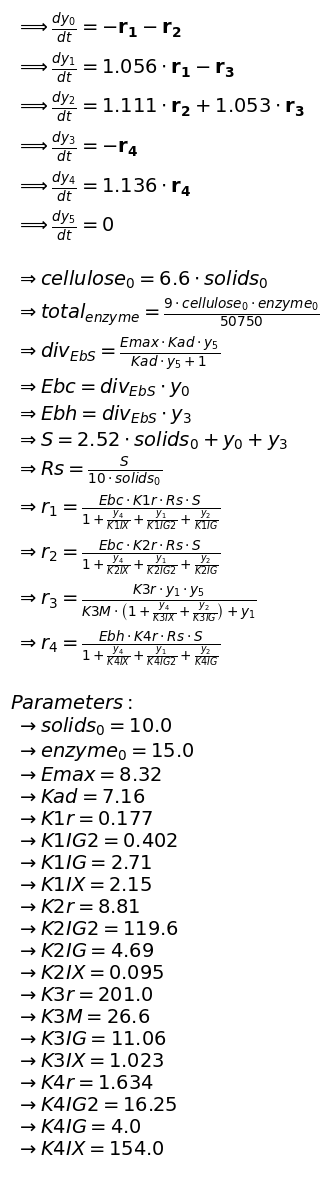

In [4]:
edo = solver.edo_functions(equations)

# Load the experimental data

In [6]:
data = pd.read_excel('angarita2015_data.xlsx')
data.drop(0, inplace=True)
# Let’s establish a technical hypothesis: since the ‘free enzyme’ is not provided, it will be considered as a fraction of the ‘total enzyme’.
data['free_enzyme'] = data['enzyme_total']*0.000085 # Arbitrary value
data.head()

,assay,figure_location,enzyme_loading,solid_loading,celulose0,hemicelulose0,enzyme_total,G0,G20,X0,time,G,G2,X,free_enzyme
1,ref_condition,fig2,10,15,99.75,12.45,0.176897,0,0,0,1,8.789644,NaN,1.4489,0.000015
2,ref_condition,fig2,10,15,99.75,12.45,0.176897,0,0,0,2,13.27508,0.367695,2.018111,0.000015
3,ref_condition,fig2,10,15,99.75,12.45,0.176897,0,0,0,4,23.06149,0.709127,2.871928,0.000015
4,ref_condition,fig2,10,15,99.75,12.45,0.176897,0,0,0,6,28.81553,0.814183,3.221216,0.000015
5,ref_condition,fig2,10,15,99.75,12.45,0.176897,0,0,0,8,33.02913,0.945502,3.531695,0.000015


# Solve the EDO

Solve the ODE from t = 0 to t = 100, with initial conditions from "assay" = "ref_condition":

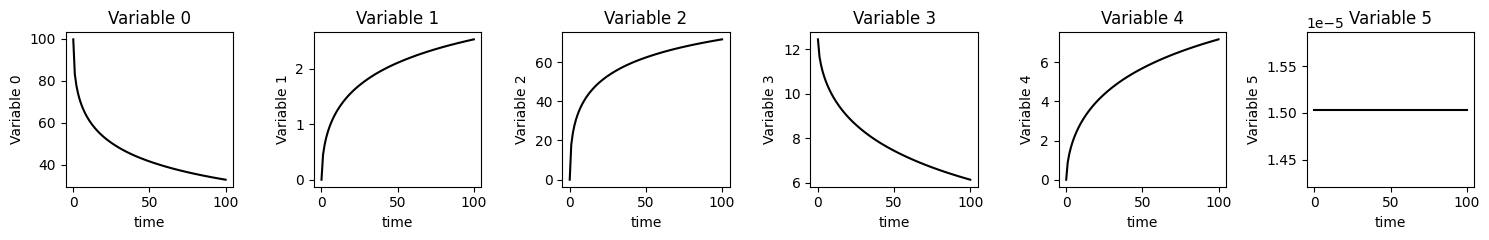

In [7]:
# Define the DataFrame columns with the initial conditions:
initial_conditions_col = ['celulose0', 'G20', 'G0', 'hemicelulose0', 'X0', 'free_enzyme']
y0 = data.loc[ data['assay'] == 'ref_condition', initial_conditions_col ].loc[1].values
edo.solve( t_span=[0,100], y0=y0 )

# Optimize the EDO

## Set the optimization parameters and adjust the EDO

Note: the algorithm uses an optimization method called 'Differential Evolution'. That’s why it takes so long.

  0%|          | 0/100 [00:00<?, ?it/s]

 53%|█████▎    | 53/100 [53:12<47:10, 60.23s/it]  


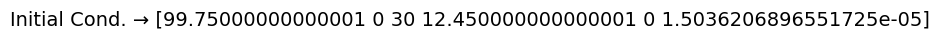

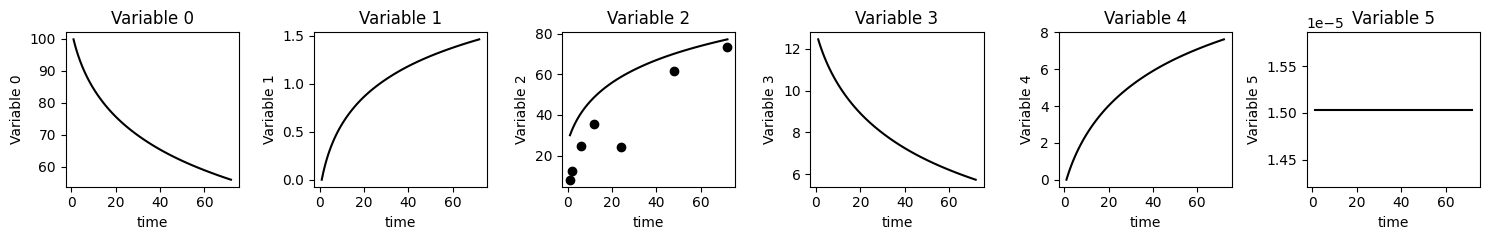

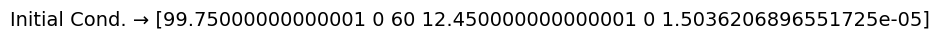

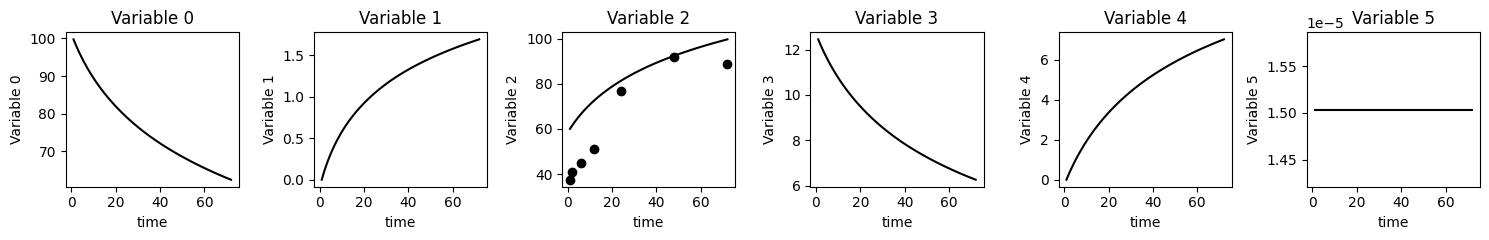

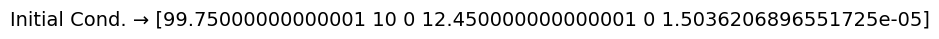

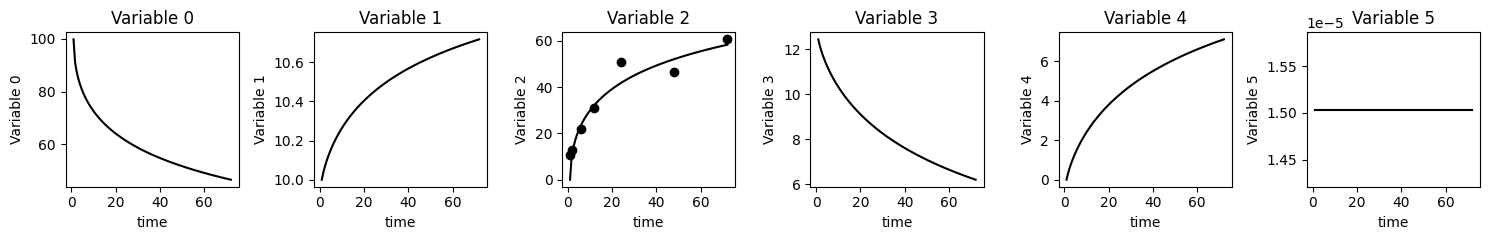

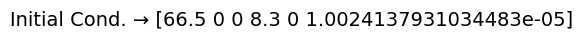

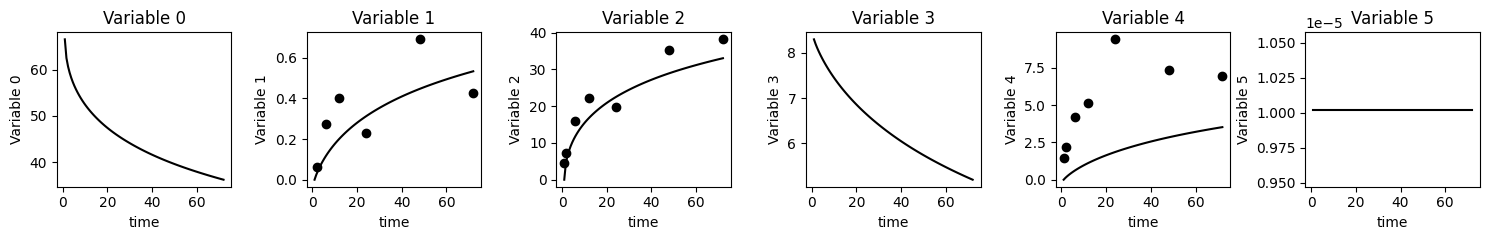

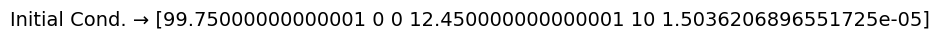

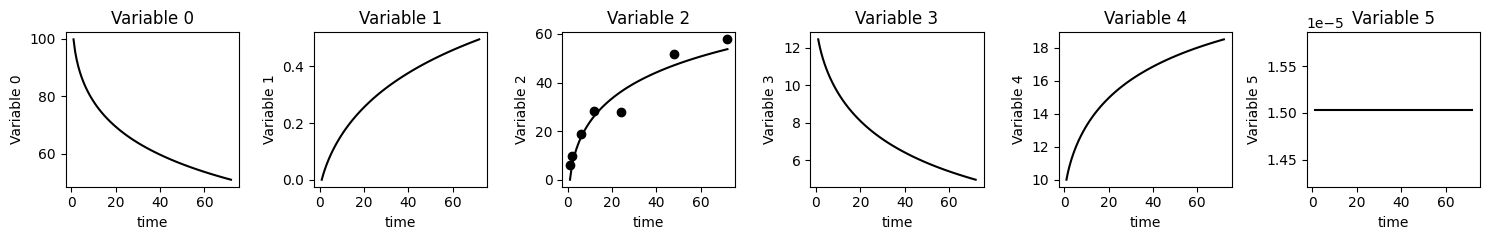

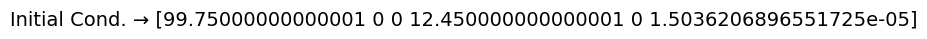

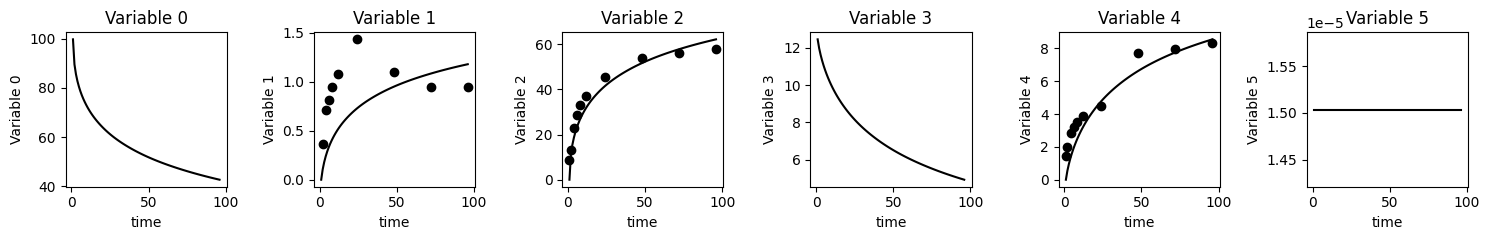

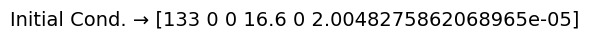

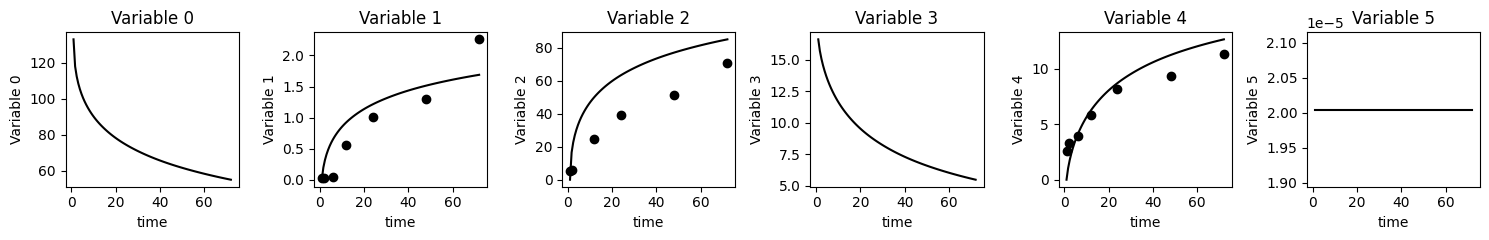

In [8]:
bounds = {
        # 'solids0': 10.0,
        # 'enzyme0': 15.0,
        # 'Emax': 8.32,
        # 'Kad': 7.16,
        'K1r': (0.0001, 1),
        'K1IG2': (0.1, 50),
        'K1IG': (1, 100),
        'K1IX': (0.001, 4),
        'K2r': (0.1, 20),
        'K2IG2': (50, 500),
        'K2IG': (1, 200),
        'K2IX': (0.01, 1),
        'K3r': (100, 500),
        'K3M': (0.1, 100),
        'K3IG': (5, 80),
        'K3IX': (0.5, 10),
        'K4r': (0.1, 3),
        'K4IG2': (0.1, 60),
        'K4IG': (1, 1000),
        'K4IX': (50, 500)
        }

# Let's choose the adjust with the conditions where enzyme_loading = 10
edo.optimize(
    data.loc[ data['enzyme_loading'] == 10],
    initial_conditions_col,
    [None, 'G2', 'G', None, 'X', None],
    'time',
    bounds
    )

Optimal parameters

In [11]:
edo.opt_result

             message: Optimization terminated successfully.
             success: True
                 fun: 63.37933176795755
                   x: [ 8.705e-03  7.164e+00 ...  3.138e+01  1.663e+02]
                 nit: 53
                nfev: 13589
          population: [[ 8.943e-03  7.164e+00 ...  3.139e+01  1.663e+02]
                       [ 3.138e-02  2.593e+01 ...  2.563e+02  3.120e+02]
                       ...
                       [ 1.165e-02  1.798e+01 ...  5.750e+01  1.585e+02]
                       [ 8.307e-03  2.730e+01 ...  5.924e+02  3.682e+02]]
 population_energies: [ 6.338e+01  6.509e+01 ...  6.377e+01  6.451e+01]
                 jac: [-5.213e-03  1.819e-04 ...  1.049e-02  1.606e-04]

In [9]:
edo.opt_params

{'K1r': np.float64(0.00870469066441185),
 'K1IG2': np.float64(7.1636543682143925),
 'K1IG': np.float64(96.95435388252854),
 'K1IX': np.float64(2.39957914608202),
 'K2r': np.float64(5.0253472058060815),
 'K2IG2': np.float64(491.93110369253645),
 'K2IG': np.float64(1.0),
 'K2IX': np.float64(1.0),
 'K3r': np.float64(288.8413926284212),
 'K3M': np.float64(48.154721830494374),
 'K3IG': np.float64(61.9026705365594),
 'K3IX': np.float64(5.522589304721267),
 'K4r': np.float64(0.32790843714623114),
 'K4IG2': np.float64(30.850459063492785),
 'K4IG': np.float64(31.38493498557147),
 'K4IX': np.float64(166.31698373169633)}